In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
import numpy as np
import pandas as pd 
import warnings 
from glob import glob 
from skimage.io import imread
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image
from keras.applications.nasnet import NASNetMobile
from keras.applications.xception import Xception
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,Conv2D
from keras.models import Model
from keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.python.keras.optimizers import *
import tensorflow as tf



In [ ]:
import tensorflow as tf

from tensorflow.keras.optimizers import Adam 

In [ ]:
warnings.filterwarnings('ignore')
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
TRAINING_RATE = 0.0001

In [ ]:
#read the train and test dataset
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory(
            '/content/drive/MyDrive/data/training',
            target_size = IMAGE_SIZE,
            class_mode = 'categorical',
            batch_size = 32)

testing_set = test_datagen.flow_from_directory(
            '/content/drive/MyDrive/data/validation',
            target_size = IMAGE_SIZE,
            class_mode = 'categorical',
            batch_size = 32)

classes = {v: k for k, v in training_set.class_indices.items()}
classes

Found 1659 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}

In [ ]:
#Model
input_shape = INPUT_SHAPE
inputs = Input(input_shape)
input_tensor = Input(shape= (128,128,3))
xception = Xception(include_top=False, input_shape = input_shape)(inputs)
nas_net = NASNetMobile(input_tensor = input_tensor, include_top = False, weights = 'imagenet')(inputs)

#output
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(xception), GlobalAveragePooling2D()(nas_net)])
outputs = Dropout(0.5)(outputs)
outputs = Dense(len(classes), activation='softmax')(outputs)

# Set Optimizer
opt = Adam(lr=0.0001)

model = Model(inputs, outputs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 4, 4, 2048)   20861480    input_1[0][0]                    
__________________________________________________________________________________________________
NASNet (Functional)             (None, 4, 4, 1056)   4269716     input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           xception[0][0]                   
______________________________________________________________________________________________

In [ ]:
# Training
history = model.fit(training_set,
                    steps_per_epoch= 50,
                    epochs= 10,
                    validation_data= testing_set,
                    validation_steps = 30)

Epoch 1/10
50/50 [==============================] - 713s 14s/step - loss: 1.6504 - accuracy: 0.2502 - val_loss: 1.7471 - val_accuracy: 0.2927
Epoch 2/10
50/50 [==============================] - 589s 12s/step - loss: 1.2510 - accuracy: 0.4759
Epoch 3/10
50/50 [==============================] - 592s 12s/step - loss: 0.8605 - accuracy: 0.6721
Epoch 4/10
50/50 [==============================] - 591s 12s/step - loss: 0.5224 - accuracy: 0.8382
Epoch 5/10
50/50 [==============================] - 598s 12s/step - loss: 0.3202 - accuracy: 0.9141
Epoch 6/10
50/50 [==============================] - 610s 12s/step - loss: 0.1772 - accuracy: 0.9580
Epoch 7/10
50/50 [==============================] - 606s 12s/step - loss: 0.1046 - accuracy: 0.9831
Epoch 8/10
50/50 [==============================] - 603s 12s/step - loss: 0.0796 - accuracy: 0.9818
Epoch 9/10
50/50 [==============================] - 686s 14s/step - loss: 0.0490 - accuracy: 0.9937
Epoch 10/10
50/50 [==============================] - 659s 

In [ ]:
len(training_set)

52

In [ ]:
model.save("/content/drive/MyDrive/data/LastModel.h5")
model.save_weights("/content/drive/MyDrive/data/LastModelWeights.h5") 

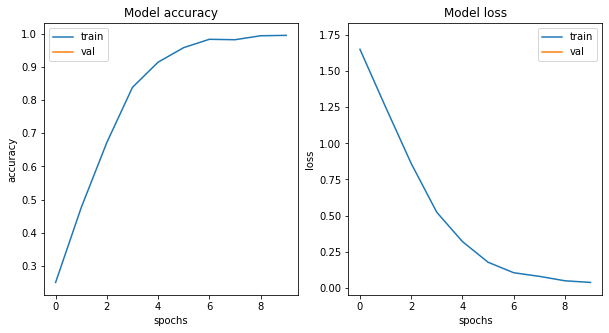

In [ ]:

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax = ax.ravel()
for i, met in enumerate(['accuracy','loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('spochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
plt.show()

In [ ]:
def get_predictions(img):
    test_img = tf.keras.preprocessing.image.load_img(img, target_size = (128, 128, 3))
    test_img = tf.keras.preprocessing.image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    pred = model.predict(test_img)
    return  np.argmax(pred)

img ='/content/drive/MyDrive/data/1008_right.jpeg'
get_predictions(img)

3